In [28]:
import mlflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
%matplotlib inline

In [4]:
df = pd.read_csv("C:/Users/andre/downloads/kyphosis.csv", sep=',', header=0)

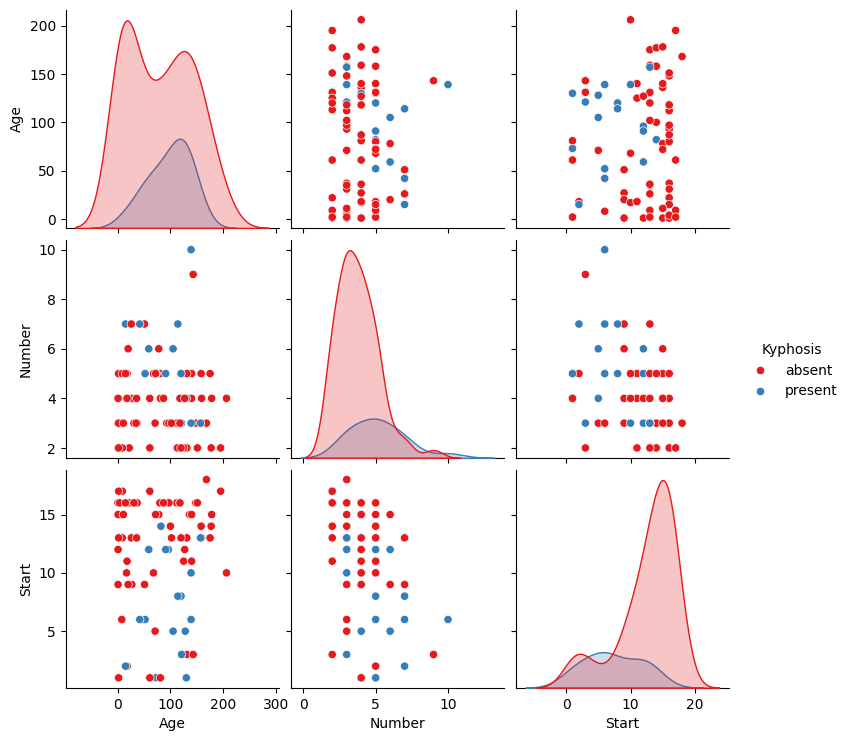

In [5]:
df.head(3)

sns.pairplot(df, hue='Kyphosis', palette='Set1')

<Axes: xlabel='count', ylabel='Kyphosis'>

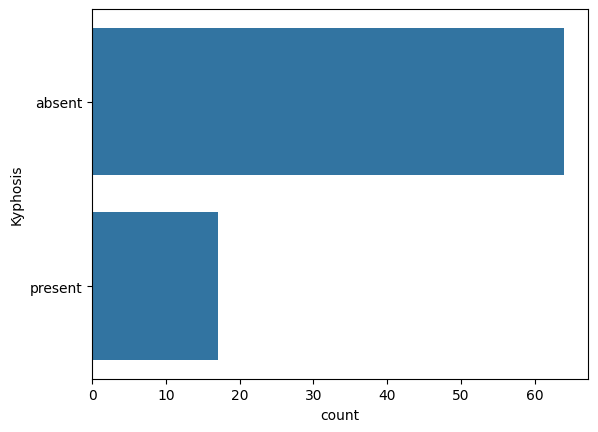

In [ ]:
df['Kyphosis'].value_counts()
sns.countplot(df['Kyphosis'])

Classes desbalanceadas

In [8]:
# 
X = df.drop('Kyphosis',axis=1)
y = df['Kyphosis']

In [ ]:
# Aplicar oversampling
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(X, y)

# Log do oversampling no MLFlow
mlflow.set_experiment("classificacao_mlflow")

with mlflow.start_run():
    mlflow.log_param("oversample", "SMOTE")
    mlflow.log_param("strategy", "balance")


2025/09/05 23:23:42 INFO mlflow.tracking.fluent: Experiment with name 'classificacao_oversample' does not exist. Creating a new experiment.


In [11]:
print("Distribuição original:", y.shape)
print("Distribuição após oversampling:",y_res.shape)


Distribuição original: (81,)
Distribuição após oversampling: (128,)


In [19]:
df = pd.DataFrame(x_res, columns=X.columns)
df["Kyphosis"] = y_res

In [21]:
df

,Age,Number,Start,Kyphosis
0,71,3,5,absent
1,158,3,14,absent
2,128,4,5,present
3,2,5,1,absent
4,1,4,15,absent
...,...,...,...,...
123,114,5,6,present
124,138,3,9,present
125,122,5,7,present
126,71,5,13,present


<Axes: xlabel='count', ylabel='Kyphosis'>

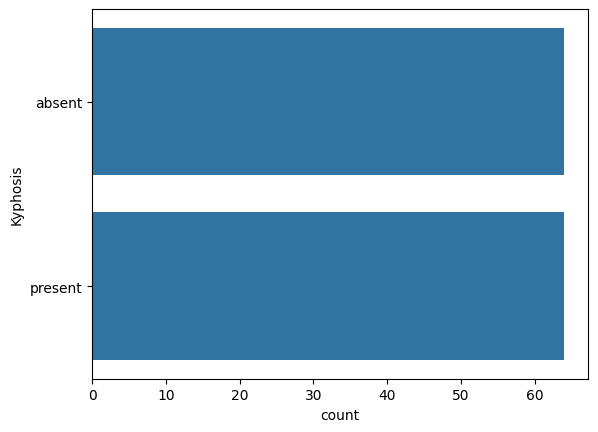

In [22]:
df['Kyphosis'].value_counts()
sns.countplot(df['Kyphosis'])

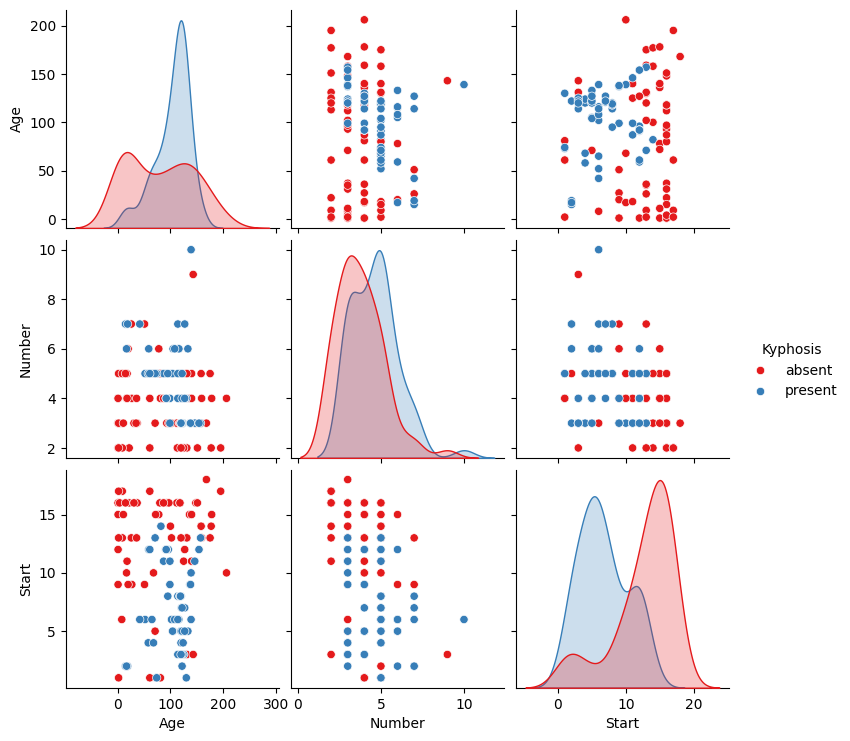

In [ ]:
# Distribiução após aplicação do oversampling (SMOTE)
df.head(3)

sns.pairplot(df, hue='Kyphosis', palette='Set1')

In [24]:
# Dividindo dados de treino e teste(30% para teste)
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.30)

In [59]:
with mlflow.start_run(run_name="DecisionTree"):
    params = {"max_depth": 5, "criterion": "gini"}
    dtree = DecisionTreeClassifier(**params, random_state=59)
    dtree.fit(X_train, y_train)
    y_pred = dtree.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label='present')

    # Log no MLflow
    mlflow.log_params(params)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)
    mlflow.sklearn.log_model(clf, "decision_tree_model")

    print("\n--- Decision Tree ---")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print(classification_report(y_test, y_pred))

2025/09/06 00:08:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/06 00:10:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Decision Tree ---
Accuracy: 0.8717948717948718
F1 Score: 0.8780487804878049
              precision    recall  f1-score   support

      absent       0.80      0.94      0.86        17
     present       0.95      0.82      0.88        22

    accuracy                           0.87        39
   macro avg       0.87      0.88      0.87        39
weighted avg       0.88      0.87      0.87        39



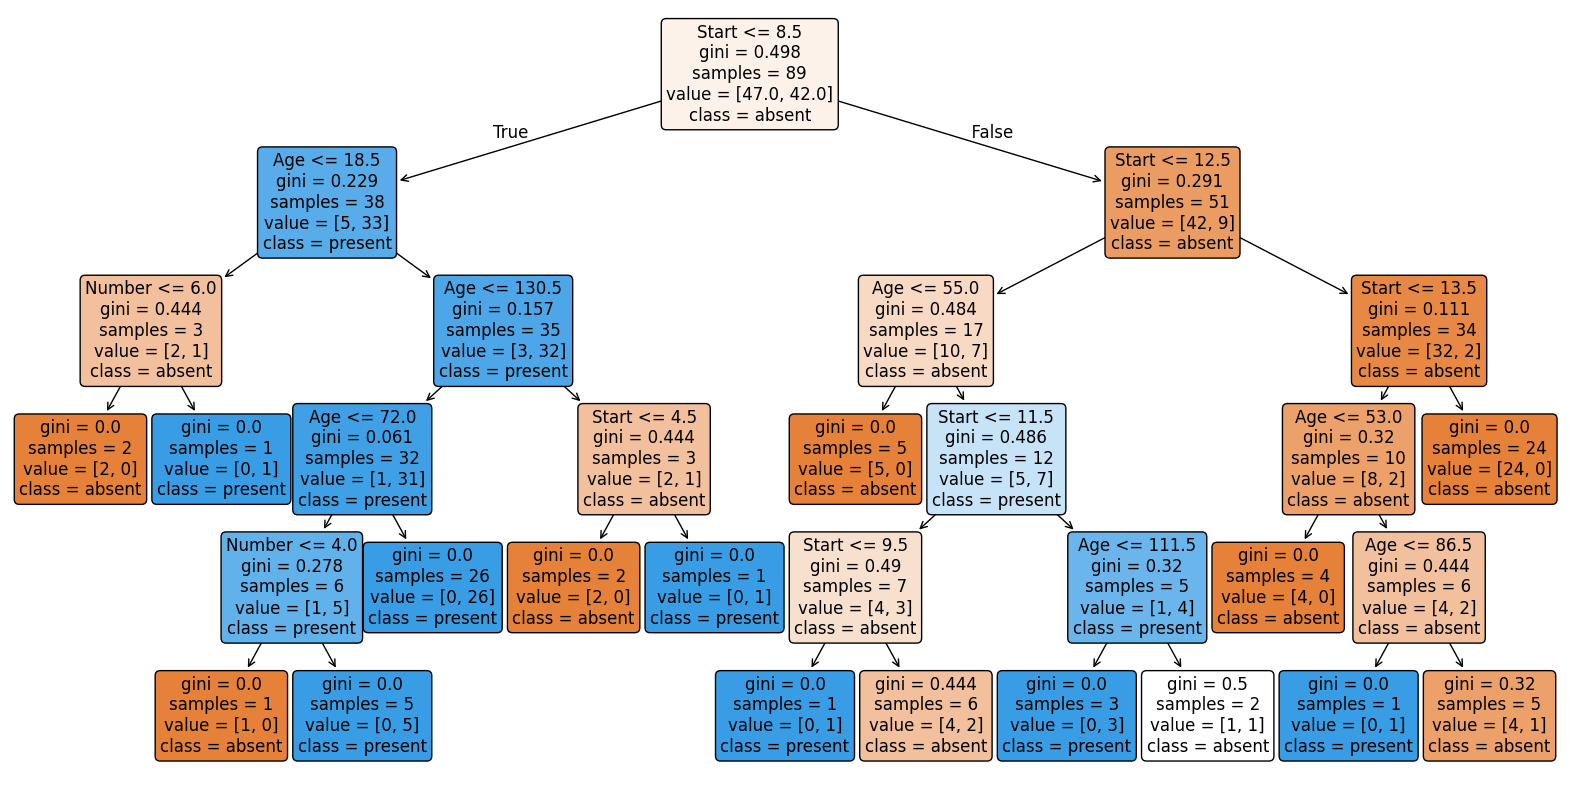

In [ ]:

features = list(df.columns[:-1])  # todas as colunas exceto 'target'

plt.figure(figsize=(20,10))
plot_tree(dtree, feature_names=features, class_names=["absent","present"],
          filled=True, rounded=True, fontsize=12)
plt.show() 


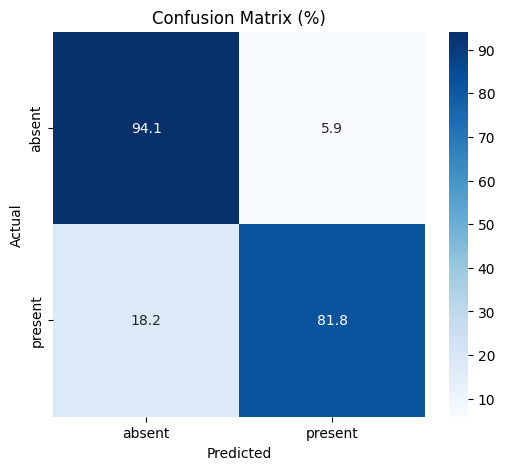

In [43]:
cm = confusion_matrix(y_test, y_pred, labels=["absent", "present"])

# Converter para percentuais
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plotar com Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["absent", "present"],
            yticklabels=["absent", "present"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (%)")
plt.show()

In [44]:
with mlflow.start_run(run_name="RandomForest"):
    params = {"n_estimators": 100, "max_depth": 5}
    clf = RandomForestClassifier(**params, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label='present')

    # Log no MLflow
    mlflow.log_params(params)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)
    mlflow.sklearn.log_model(clf, "random_forest_model")

    print("\n--- Random Forest ---")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print(classification_report(y_test, y_pred))


2025/09/05 23:49:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/05 23:51:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Random Forest ---
Accuracy: 0.8974358974358975
F1 Score: 0.9090909090909091
              precision    recall  f1-score   support

      absent       0.88      0.88      0.88        17
     present       0.91      0.91      0.91        22

    accuracy                           0.90        39
   macro avg       0.90      0.90      0.90        39
weighted avg       0.90      0.90      0.90        39

